# Projet 3MA201 encadré par Barbaras Gris
## Groupe Lyna, Garance, Victor, Thomas N

# Implémentation python de la solution de l'appariement inexact dans le cas des petites déformations (rapport de Thomas Nguyen pour le 06/02/2023)

Numéro étudiant : 28626005

Mail : thomas.nguyen@etu.sorbonne-universite.fr

<div class="alert alert-block alert-info">
Ce rapport étant surtout mon support de travail pour ces deux premières semaines, il y a beaucoup de "notes à moi-même" dans ce fichier, de choses que j'ai marquées à finir où à faire attention par exemple. Il y a aussi des ébauches ou même des choses fausses laissées délibérement (car après tout, on ne jette jamais du code). Désolé d'avance du manque de mise en forme et de la rédaction impropre !
</div>

Je remets le lien du site où l'on peut trouver des données : http://ubee.enseeiht.fr/ShapesDataset/

### Objectifs :

   - arriver à faire la descente de gradient qui nous intéresse 
   - s'introduire au module PyTorch, pour comprendre comment Mme.Gris a extrait les formes du site (mail du 24/01) et  comprendre comment calculer des gradients

## Contexte

Se référer au rapport de Lyna de la séance du mardi 24 janvier pour plus de précisions. Je me contente d'écrire ce qui m'aidera pour la suite, sans être rigoureux.

Avec un appariement $\varphi$ tel que $\varphi \cdot S = T$, on cherche : $inf\{{c(\varphi) +  \lambda Dist({\varphi \cdot S},T)})^2\}$.

On se restreint au cas des petites déformations, telles qu'avec un champ de vecteurs $V \in \mathscr{C}^{n}(\mathbb{R}^2,\mathbb{R}^2)$ on écrive $\varphi = I_2 + v$, $v \in V$ et $c(\alpha) = |v|^2 _V$.

Ainsi, $\varphi \cdot S = (x_1 + v(x_1), ..., x_n + v(x_n))$.

Pour l'implémentation, on va considérer une grille $(Z_{k})_{K\in [[1;D ]]}$ de points deux-à-deux distincts et $V = \{ x \mapsto \displaystyle\sum_{k=1} ^{D} \alpha_k e^{\frac{-|x-z_{k}|^2}{2\sigma^{2}}}| \alpha_k \in \mathbb{R}^2 , k \in [[1,D]]\} $ avec $\sigma >0$.

<div class="alert alert-block alert-info">
<b>Première difficulté :</b> je n'ai strictement aucune idée pour comment choisir les $\alpha_k$. Dans l'attente d'une idée, je compte juste les choisir un peu au hasard et de tenter de visualiser le champ de vecteurs.
</div>

On va faire une descente de gradient sur :  
$$J : \alpha = (\alpha_1 , ..., \alpha_D) \in (\mathbb{R}^2)^D \mapsto \displaystyle\sum_{k=1} ^{D} |\alpha_k|^2 + \lambda Dist(\varphi_\alpha \cdot S,T)^2 $$

Où : $\varphi_\alpha = I_2 + \displaystyle\sum_{k=1} ^{D} \displaystyle\sum_{l=1} ^{2} v_{k,l}^{\alpha_k (l)}$ et $v_k : x \mapsto e^{\frac{-|x-z_{k}|^2}{2\sigma^{2}}}e_l$ avec $e_1 = (1,0), e_2 = (0,1)$

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Distance

On peut choisir d'utiliser la distance euclidienne, mais considérons plutôt :

Avec $A = (a_1 , ... , a_n)$ et $B = (b_1 , ... , b_n)$ deux listes de $n$ points de $\mathbb{R}^2$,

$$Dist(A,B) = \max\{\max_{i}{(\min_{j}{|a_i - b_j|})}, {\max_{j}{(\min_{i}{|a_i - b_j|})}\}}$$

In [5]:
def distfaux(A,B): # cette implémentation est fausse, je viens de comprendre que A et B sont des listes de n points de R^2
    if len(A) != len(B):
        raise Exception("A et B n'ont pas le même nombre de points !")
    n = len(A)
    
    res1 = 0
    f1 = False #drapeau 
    for i in range(0,n):
        for j in range(0,n):
            if not f1: 
                w = np.min(np.abs(A[i],B[j]))
                f1 = True
            else: 
                if w < np.min(np.abs(A[i],B[j])):
                    w = np.min(np.abs(A[i],B[j]))
        if w > np.max(np.abs(A[i],B[j])):
            w = np.max(np.abs(A[i],B[j]))
        res1 = w
    
    res2 = 0
    f2 = False #drapeau 
    for j in range(0,n):
        for i in range(0,n):
            if not f12: 
                m = np.min(np.abs(A[i],B[j]))
                f1 = True
            else: 
                if m < np.min(np.abs(A[i],B[j])):
                    m = np.min(np.abs(A[i],B[j]))
        if m > np.max(np.abs(A[i],B[j])):
            m = np.max(np.abs(A[i],B[j]))
        res2 = m
    
    if res1 >= res2:
        return res1
    else:
        return res2

In [128]:
def maxmin(A,B): # max sur les i du min sur les j, avec A et B des listes de 2-uplets
    
    if len(A) != len(B):
        raise Exception("A et B n'ont pas le même nombre de points !")
        
    max_list = []
    for a in A:
        min_list = []
        for b in B:
            c = (a[0]-b[0],a[1]-b[1])
            min_list.append(np.linalg.norm(c))
        max_list.append(np.min(min_list))
    return np.max(max_list)


def dist(A,B):
    return max(maxmin(A,B),maxmin(B,A))

<div class="alert alert-block alert-info">
Cette implémentation m'a l'air de marcher, mais je n'ai pas cherché de jeu de test adéquat : à faire pour être sûr de ne rien fausser par la suite.
</div>

0.8085598308103118 39.0


39.0

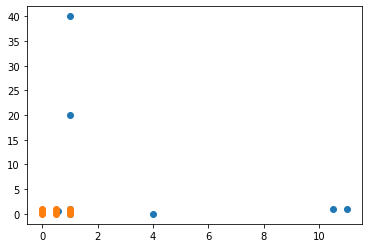

In [129]:
At = [(0.0, 0.0), (0.0, 0.5), (0.0, 1.0), (0.5, 0.0), (0.5, 0.5), (0.5, 1.0), (1.0, 0.0), (1.0, 0.5), (1.0, 1.0)]
Bt = [(1.0, 0.0), (0.0, 0.85), (1.0, 1.0), (4, 0.0), (0.555, 0.588), (10.5, 1.0), (1.0, 20.0), (1.0, 40), (11.0, 1.0)]
print(maxmin(At,Bt),maxmin(Bt,At))
dessinergrille(Bt)
dessinergrille(At)
dist(At,Bt)

## Grille

Il faut se choisir une grille $(Z_{k})_{K\in [[1;D ]]}$ de points deux-à-deux distincts, je vais choisir le même pas $\epsilon$ verticalement et horizontalement, sachant que sur le site http://ubee.enseeiht.fr/ShapesDataset/ les figures ont l'air d'être dans le carré $[0,1]^2$ (en téléchargeant les plaintext on le voit, dans le doute je laisse la possibilité de personnaliser).
Je compte les points de la grille à partir d'en bas à gauche jusqu'à atteindre le point en haut à droite. 

In [6]:
def grille(pas, gauche=0, droite=1):
    g = [] 
    for x in np.arange(gauche,droite+pas,pas): # à x fixé, on compte donc en montant colonne par colonne 
        for y in np.arange(gauche,droite+pas,pas):
            g.append((x,y))
    return g

def dessinergrille(G,u=True): # avec G liste de 2-uplets, u pour afficher une grille cosmétique (dont je n'ai même pas encore pris la peine d'aligner avec celle qui nous intéresse)
    X = [] ; Y = []
    for i in range(len(G)):
        X.append(G[i][0])
        Y.append(G[i][1])
        
    plt.plot(X,Y, marker= 'o', linestyle='none')
    if u : 
        plt.grid()
    plt.show
    
    
#test avec un pas de 0.5, on a bien neuf points dans l'ordre attendu 
print(grille(0.5))
dessinergrille(grille(0.5))


[(0.0, 0.0), (0.0, 0.5), (0.0, 1.0), (0.5, 0.0), (0.5, 0.5), (0.5, 1.0), (1.0, 0.0), (1.0, 0.5), (1.0, 1.0)]


<div class="alert alert-block alert-info">
Implémentation à modifier pour choisir le nombre de points k...
</div>

In [7]:
dessinergrille(grille(0.05))

## Champ de vecteurs V

Rappel : $V = \{ x \mapsto \displaystyle\sum_{k=1} ^{D} \alpha_k e^{\frac{-|x-z_{k}|^2}{2\sigma^{2}}}| \alpha_k \in \mathbb{R}^2 , k \in [[1,D]]\} $ avec $\sigma >0$

Avec la dernière fonction, j'ai la liste des points dans ma grille. Mais pour dessiner le champ de vecteurs je vais devoir refaire une grille avec la fonction meshgrid de Numpy, dans le but d'utiliser la fonction quiver pour la représentation graphique.

In [122]:
def dessinV(Lalpha, G, pas, sigma, gauche=0, droite=1): 
    # Lalpha est la liste des alpha_k 
    # G une grille dans le sens liste de points comme au-dessus
    # sigma positif
    
    D = len(Lalpha)
    h = int(1.0/pas)
    x,y = np.meshgrid(np.linspace(gauche, droite, h),np.linspace(gauche, droite, h))
    
    v1 = 0
    for k in range(0,D):
        temp1, temp2 = G[k]
        v1 += Lalpha[k][0] * np.exp(((-1)*np.linalg.norm((x-temp1,y-temp2)))/(2*(sigma**2)))
    v2 = 0
    for k in range(0,D):
        temp1, temp2 = G[k]
        v2 += Lalpha[k][1] * np.exp(((-1)*np.linalg.norm((x-temp1,y-temp2)))/(2*(sigma**2)))
        
    plt.quiver(x, y, v1, v2)
    plt.title("Champ de vecteurs V")
    plt.grid()
    plt.show()

In [123]:
len(grille(0.2))

36

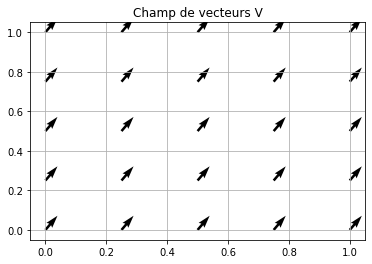

In [124]:
dessinV(abs(0.5 * np.random.randn(36,2) - 0.5), grille(0.2), 0.2, 4)

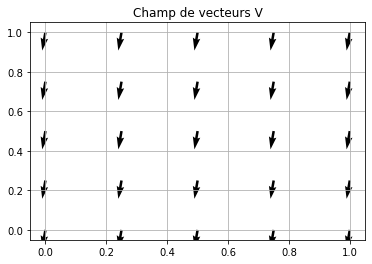

In [125]:
dessinV(np.random.randn(36,2), grille(0.2), 0.2, 1)

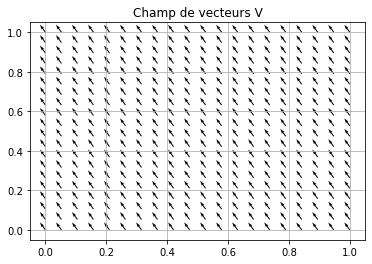

In [106]:
dessinV(np.random.randn(441,2), grille(0.05), 0.05, 0.7)

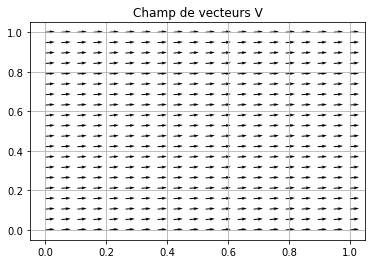

In [109]:
dessinV(np.random.randn(441,2), grille(0.05), 0.05, 0.7)

<div class="alert alert-block alert-info">
Je n'ai aucun graphe satisfaisant. Qu'importe ce que je fasse, il semblerait que tous les vecteurs ont même sens et même direction... 
Ou bien mon implémentation est totalement fausse, ou bien ma façon de tester a peu de sens...
</div>

## Descente de gradient, pour fonction à deux variables

On va faire une descente de gradient sur :  
$$J : \alpha = (\alpha_1 , ..., \alpha_D) \in (\mathbb{R}^2)^D \mapsto \displaystyle\sum_{k=1} ^{D} |\alpha_k|^2 + \lambda Dist(\varphi_\alpha \cdot S,T)^2 $$

Où : $\varphi_\alpha = I_2 + \displaystyle\sum_{k=1} ^{D} \displaystyle\sum_{l=1} ^{2} v_{k,l}^{\alpha_k (l)}$ et $v_k : x \mapsto e^{\frac{-|x-z_{k}|^2}{2\sigma^{2}}}e_l$ avec $e_1 = (1,0), e_2 = (0,1)$

Dans un premier temps j'écris mon implémentation pour $\alpha = (\alpha_1, \alpha_2)$, juste pour me mettre au clair de ce que je dois modifier pour aller jusqu'à $\alpha_D$.

In [126]:
def desgrad2(J, a1, a2, lr, eps=1e-6, maxiter=1000):
    # J la fonction 
    # a1 a2 valeurs initiales
    # lr le taux d'apprentissage (learning rate)
    # eps la précision
    # maxiter le nombre maximum d'itération
    
    g = 1
    i = 0
    while abs(g)>eps:
        ga1 = (J(a1+eps,a2)-J(a1-eps,a2))/(2*eps) #calcul dJ/da1, estimation taux d'accroissement centré
        ga2 = (J(a1,a2+eps)-J(a1,a2-eps))/(2*eps) #calcul dJ/da2
        g = np.linalg.norm(ga1,ga2)
        a1 = a1 - lr*ga1 #on va vers le bas selon a1
        a2 = a2 - lr*ga2 #on va vers le bas selon a2
        i += 1
        if i > maxiter :
            raise Exception("Nombre d'itérations trop élevé !")
    return a1,a2

<div class="alert alert-block alert-info">
On voit que la définiton de cette fonction doit juste être modifiée au moment du calcul des dérivées partielles selon chaque composante de $\alpha$, enfin si jamais j'ai bien compris ce qui doit être fait. Après plusieurs échecs, je suis en train de chercher une utilisation de la fonction np.diff, je ne me suis pas encore informé sur le module PyTorch. 

Bilan de ces deux premières semaines, j'estime avoir été trop lent. J'estime même que ce que je présente ici est assez catastrophique ! J'ai en revanche assez bien ciblé mes soucis.

En groupe, mes camarades m'ont essentiellement expliqué la théorie vue en présence la dernière fois, notamment sur la proposition de distance que je ne trouvais pas intuitive. Par contre, nous n'avons pas réussi à trouver un temps pour travailler tous ensemble : nous nous étions réunis en visioconférence que très peu de temps pour mettre Victor (absent première séance) sur les roues avec un court résumé. C'est un point qu'on doit améliorer : j'ai bien vu que tout seul, mon incompréhension des concepts m'a rendu inefficace ! 
J'ai perdu beaucoup de mon temps à faire des fouilles sur Internet à chercher des ressources sur la descente de gradient, pour tenter de mieux comprendre ce que je voulais faire. Mes implémentations m'ont pris un temps conséquent mais je ne suis même pas certain de leur justesse : il faut que je réfléchisse à des jeux de test pour elles.
D'ailleurs, je vais m'informer au plus vite sur la mise en place d'un GitHub.
</div>